#### Part2 튼튼한 GAN 만들기
---
Chapter 8. 얼굴 이미지

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
import h5py
import numpy
import matplotlib.pyplot as plt
import zipfile
import imageio
import os

In [4]:
import torchvision.datasets

In [9]:
hdf5_file = 'mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.h5py'
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:
  count = 0
  with zipfile.ZipFile('mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.zip', 'r') as zf:
    for i in zf.namelist():
      if (i[-4:] == '.jpg'):
        # extract image
        ofile = zf.extract(i)
        img = imageio.imread(ofile)
        os.remove(ofile)
        hf.create_dataset('img_align_celeba/' + str(count) + '.jpg', data=img, compression="gzip", compression_opts=9)
        count += 1
        if (count % 1000 == 0):
          print("images done ..", count)
          pass
        if (count == total_images):
          break
        pass
        
      pass
    pass

images done .. 1000
images done .. 2000
images done .. 3000
images done .. 4000
images done .. 5000
images done .. 6000
images done .. 7000
images done .. 8000
images done .. 9000
images done .. 10000
images done .. 11000
images done .. 12000
images done .. 13000
images done .. 14000
images done .. 15000
images done .. 16000
images done .. 17000
images done .. 18000
images done .. 19000
images done .. 20000


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [16]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [17]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [18]:
# Dataset 객체 생성
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.h5py')

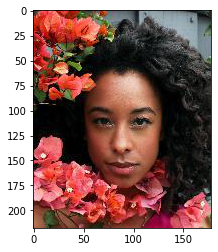

In [19]:
# 데이터 확인
celeba_dataset.plot_image(43)

In [20]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [21]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [25]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [26]:
%%time
# 판별기가 실제 데이터와 임의의 노이즈를 구별할 수 있는지 테스트

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 5min 40s, sys: 5.24 s, total: 5min 45s
Wall time: 5min 44s


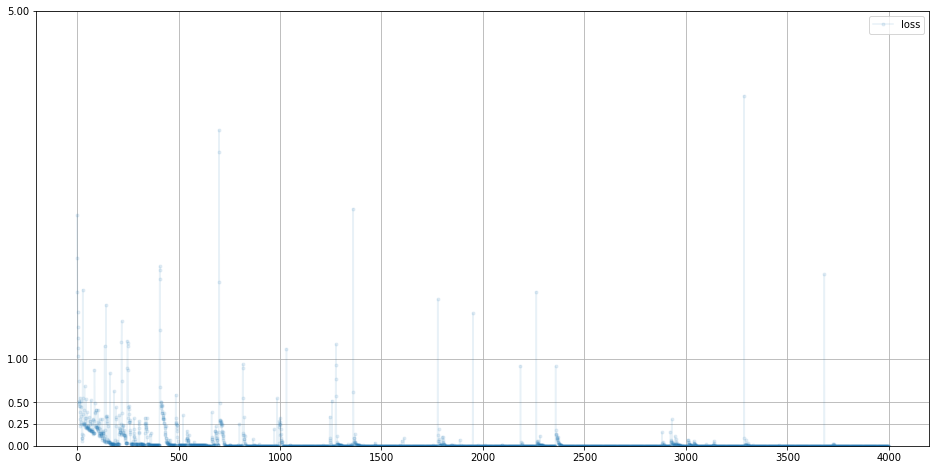

In [27]:
D.plot_progress()

In [28]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

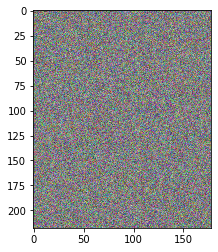

In [30]:
G = Generator()
# 모델을 CUDA에 배치
G.to(device)

output = G.forward(generate_random_seed(199))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [31]:
%%time 

# 판별기 및 생성기 생성

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for image_data_tensor in celeba_dataset:
    # 참에 대해 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # 거짓에 대해 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach()함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 15min 17s, sys: 8.86 s, total: 15min 26s
Wall time: 15min 24s


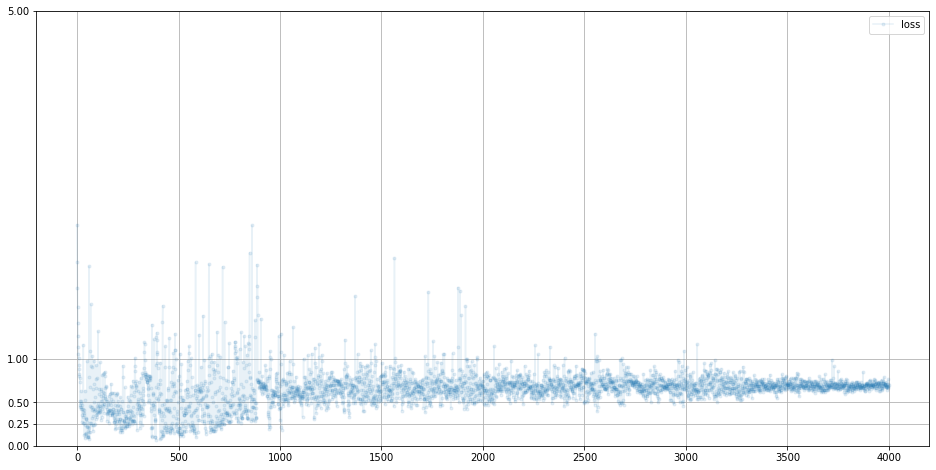

In [32]:
D.plot_progress()

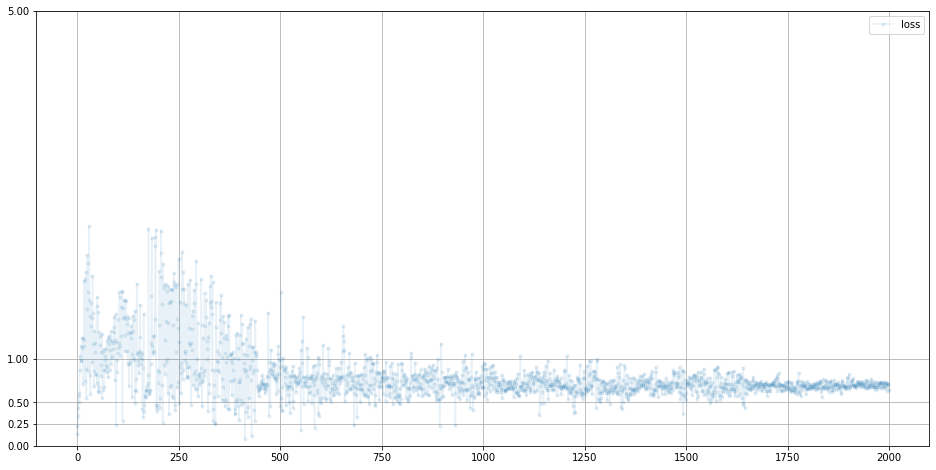

In [33]:
G.plot_progress()

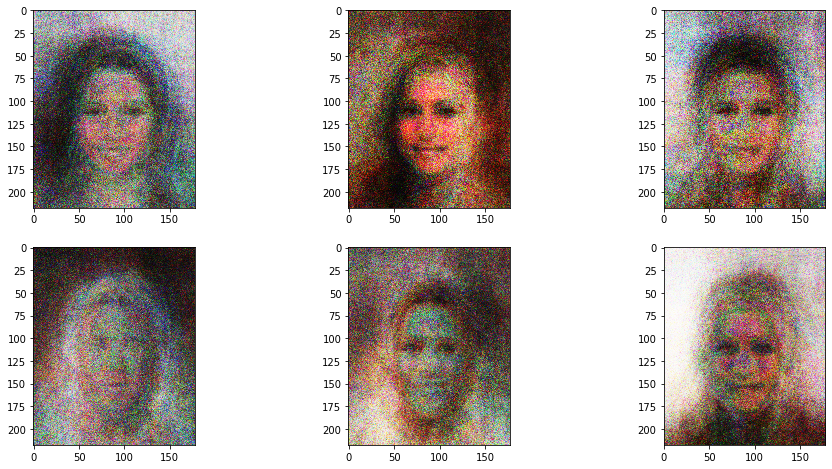

In [35]:
# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(2,3, figsize=(16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass